# Introduction to Product List Sorting (PLS)

**Workshop Level**: Beginner

**What you'll learn**: During the workshop you will learn how to train a machine learning model in Python to sort products into a list that maximizes the click-through rate (CTR). This process solves one of the classic problems in e-commerce: the virtual presentation of products, especially their order, which varies along the customer journey.


In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 0. Reading data

Input data file for e-commerce events is available in Kaggle:
+ [eCommerce events history in electronics store](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-electronics-store)
+ [EES46 Marketing Platform](https://rees46.com/)

In [35]:
!kaggle datasets download -d mkechinov/ecommerce-events-history-in-electronics-store


  0%|          | 0.00/20.3M [00:00<?, ?B/s]
  5%|▍         | 1.00M/20.3M [00:00<00:05, 3.95MB/s]
 15%|█▍        | 3.00M/20.3M [00:00<00:02, 6.90MB/s]
 30%|██▉       | 6.00M/20.3M [00:00<00:01, 12.3MB/s]
 44%|████▍     | 9.00M/20.3M [00:00<00:00, 16.4MB/s]
 69%|██████▉   | 14.0M/20.3M [00:00<00:00, 25.2MB/s]
 94%|█████████▎| 19.0M/20.3M [00:00<00:00, 31.9MB/s]
100%|██████████| 20.3M/20.3M [00:00<00:00, 21.7MB/s]


In [36]:
# unzip and delete original
import zipfile

with zipfile.ZipFile('ecommerce-events-history-in-electronics-store.zip', 'r') as zip_file:
    zip_file.extractall('input-data')


In [37]:
!del ecommerce-events-history-in-electronics-store.zip

In [38]:
# load data 
events_data = pd.read_csv('input-data/events.csv')
events_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [39]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [40]:
events_data.groupby('event_type').user_session.count()

event_type
cart         54029
purchase     37346
view        793589
Name: user_session, dtype: int64

# 1. Data preparation

### Data finding, organizing and cleaning can take up to 80 % of your Data Science projects time (IBM Data Analytics). Make sure you take this into account when planning your project. 

In [62]:
# get only impressions and orders 
df = events_data[events_data.event_type.isin(['view','purchase'])]

# count number of orders and impressions per product
df_pivot = pd.pivot_table(df, index=['product_id','price'], columns=['event_type'], values='user_session', aggfunc=pd.Series.count)
df_pivot.fillna(0, inplace=True)

df_pivot.head()

,event_type,purchase,view
product_id,price,,
102,13.02,5.0,19.0
105,14.19,3.0,664.0
109,11.52,0.0,42.0
526,12.54,5.0,30.0
561,10.76,0.0,2.0


In [63]:
df_pivot.columns.name = None
df_pivot.reset_index(inplace=True)
df_pivot.head()

,product_id,price,purchase,view
0,102,13.02,5.0,19.0
1,105,14.19,3.0,664.0
2,109,11.52,0.0,42.0
3,526,12.54,5.0,30.0
4,561,10.76,0.0,2.0


In [64]:
df_pivot.describe()

,product_id,price,purchase,view
count,5.345300e+04,53453.000000,53453.000000,53453.000000
mean,1.548572e+06,105.346161,0.698670,14.846482
std,1.303698e+06,516.781715,7.331356,97.626645
min,1.020000e+02,0.220000,0.000000,0.000000
25%,6.170760e+05,14.860000,0.000000,1.000000
50%,1.018106e+06,29.680000,0.000000,3.000000
75%,1.804712e+06,80.510000,0.000000,9.000000
max,4.183880e+06,64771.060000,564.000000,12804.000000


In [66]:
# remove products with no views
df_pivot = df_pivot[df_pivot.view > 0]
df_pivot.describe()

,product_id,price,purchase,view
count,5.345100e+04,53451.000000,53451.000000,53451.000000
mean,1.548536e+06,105.349553,0.698677,14.847037
std,1.303677e+06,516.791085,7.331492,97.628429
min,1.020000e+02,0.220000,0.000000,1.000000
25%,6.170145e+05,14.860000,0.000000,1.000000
50%,1.018060e+06,29.680000,0.000000,3.000000
75%,1.804712e+06,80.510000,0.000000,9.000000
max,4.183880e+06,64771.060000,564.000000,12804.000000


In [68]:
# create the new variable "conversion_rate" and name it cvr
df_pivot['cvr'] = df_pivot['purchase'] / df_pivot['view'] 
df_pivot.describe()

C:\Users\meira\AppData\Local\Temp/ipykernel_17952/1137817798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pivot['cvr'] = df_pivot['purchase'] / df_pivot['view']


,product_id,price,purchase,view,cvr
count,5.345100e+04,53451.000000,53451.000000,53451.000000,53451.000000
mean,1.548536e+06,105.349553,0.698677,14.847037,0.024994
std,1.303677e+06,516.791085,7.331492,97.628429,0.124387
min,1.020000e+02,0.220000,0.000000,1.000000,0.000000
25%,6.170145e+05,14.860000,0.000000,1.000000,0.000000
50%,1.018060e+06,29.680000,0.000000,3.000000,0.000000
75%,1.804712e+06,80.510000,0.000000,9.000000,0.000000
max,4.183880e+06,64771.060000,564.000000,12804.000000,5.000000


# 2. Data exploration

In [69]:
# Number of distinct products
print("number of distinct products:", df_pivot.product_id.nunique())

number of distinct products: 53451


<AxesSubplot:ylabel='Frequency'>

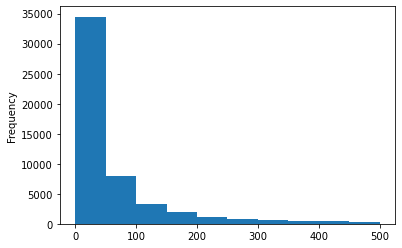

In [70]:
# create a histogram for price
df_pivot[df_pivot.price < 500]['price'].plot(kind='hist') 

# handle outliers

In [74]:
# correlation matrix and heatmap: shows the strength of linar relationship
# numeric vs. numeric variables
df_pivot[['price','cvr']].corr()

,price,cvr
price,1.000000,-0.015352
cvr,-0.015352,1.000000


# 2. Data preparation

In [75]:
# split training data into train and test (hide samples) 
np.random.seed(2808)

print("total n rows of dataset:", len(df_pivot))
train, test = train_test_split(df_pivot, test_size=0.3)
print("train", len(train)) 
print("test", len(test))

total n rows of dataset: 53451
train 37415
test 16036


# 3. Model training

In [76]:
# transform data from pandas dataframe to numpy 
y = train['cvr'].to_numpy()
x = train[['price']].to_numpy() 

In [77]:
# show the input of the first row for the prediction
x[0,]

array([10.52])

In [78]:
# show the target value (what we want to predict)
y[0]

0.0

In [79]:
# apply model to test data
# x: attributes (same as in definition of y above), y: target

model = LinearRegression()
model.fit(x,y) 
predicted = model.predict(test[['price']].to_numpy())
test['predicted_cvr'] = predicted # add column "predicted" to test data

In [80]:
test.head(3)

,product_id,price,purchase,view,cvr,predicted_cvr
5778,303780,11.70,0.0,3.0,0.0,0.025192
51088,4101018,32.06,0.0,5.0,0.0,0.025133
3262,225951,15.40,0.0,18.0,0.0,0.025181


# 4. Evaluation

In [81]:
# which cvr was predicted for the first article?
predicted[0]

0.02519220257531623

In [83]:
# check MAE
import sklearn 
sklearn.metrics.mean_absolute_error(test['cvr'].to_numpy(), predicted)

0.04424769556573792

In [85]:
# check first x products from predicted cvr and compare to order of actual cvr (rank by cvr)
print(test.sort_values(by = ['cvr'], ascending= False).head(5))

# cvr of 1 or 0.33333 => 1 impression and 1 order? => if yes, remove it from dataset? 

       product_id  price  purchase  view  cvr  predicted_cvr
48217     3830465  17.30       4.0   1.0  4.0       0.025176
23562      893363  14.60       9.0   3.0  3.0       0.025184
18345      787579   1.57       3.0   1.0  3.0       0.025222
39411     1784781  25.71       3.0   1.0  3.0       0.025152
20105      827465  16.98       2.0   1.0  2.0       0.025177


In [86]:
# products ranked by predicted cvr
print(test.sort_values(by = ['predicted_cvr'], ascending= False).head(5))

       product_id  price  purchase   view       cvr  predicted_cvr
2212       167240   0.90      10.0  112.0  0.089286       0.025224
5424       301024   1.17       0.0    4.0  0.000000       0.025223
5408       300794   1.40       0.0    1.0  0.000000       0.025222
6626       327752   1.52       0.0    1.0  0.000000       0.025222
18348      787587   1.57       0.0    6.0  0.000000       0.025222


### Now it's up to you - try to add new features to the model. You can either calculate something by yourself or you can select an existing feature. 